<h1>CP421 Advanced Data Mining Term Project</h1>
<h4>Aayush Sheth, Adam Gumenieak, Jun Cao</h4>
<h2>Movie Recomendation System on MovieLens 100K Dataset</h2>

<p>To implement our recommendation system we built a user factorization matrix as popularized by Netflix and calculated SVD through sci-kit and compared the resulting Root Mean Square Error against a collaborative filter model</p>

<h3>Imports</h3>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import sys
import pickle
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import train_test_split
from wordcloud import WordCloud, STOPWORDS

sns.set_style("dark")
plt.rcParams['patch.force_edgecolor'] = True

In [2]:
# Load data
movies = pd.read_csv('Data/movies.csv')
tags = pd.read_csv('Data/tags.csv')
ratings = pd.read_csv('Data/ratings.csv')

<h3>Data Visualization</h3>

Text(0, 0.5, 'Number of Movies')

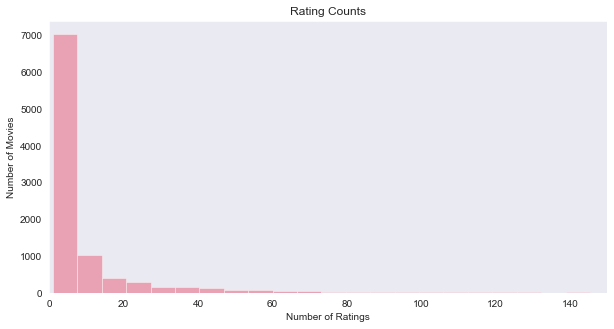

In [3]:
# preprocess for visualization

movie_data = pd.merge(ratings, movies, on='movieId')
movie_data.groupby('title')['rating'].count().sort_values(ascending=False)
ratings_mean_count = pd.DataFrame(movie_data.groupby('title')['rating'].mean())
ratings_mean_count['rating_counts'] = pd.DataFrame(movie_data.groupby('title')['rating'].count())
fig, ax = plt.subplots(figsize=(10,5)) 

counts = ratings_mean_count['rating_counts']

# plotting

sns.distplot(counts, kde=False, color="#e63756", ax=ax)
ax.grid(False)
ax.set_xlim(xmin=0, xmax=150)
ax.set_title("Rating Counts")
ax.set_xlabel("Number of Ratings")
ax.set_ylabel("Number of Movies")

Text(29.125, 0.5, 'Rating')

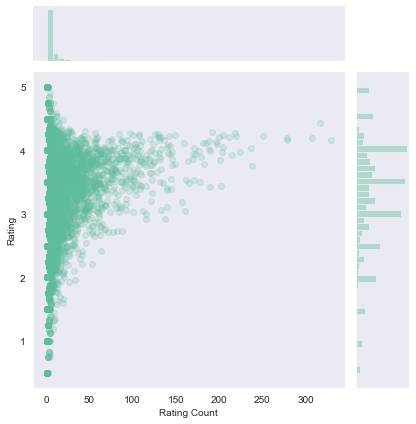

In [4]:
# plotting 
joint_plot = sns.jointplot(x='rating_counts',
                           y='rating',
                           data=ratings_mean_count,
                           alpha=0.2,
                           color="#5ebb9c"
                          )
joint_plot.ax_joint.set_xlabel("Rating Count")
joint_plot.ax_joint.set_ylabel("Rating")

<p>From the first visualization we find that most movies have little to no ratings. Looking at the second visualization we find that the more ratings a movie has the higher the rating is. Evidently, movies which we find "interesting" will be ones
that have many ratings, over 50 to be exact, and these movies will typically be of higher rating.</p>

### Filtering and Cleaning Data

In [5]:
movies['genres'] = movies['genres'].str.replace('|',' ')

print("We have {} unique movies in movies dataset.".format(len(movies.movieId.unique())))

We have 9742 unique movies in movies dataset.


In [6]:
print("We have {} unique movies ratings dataset.".format(len(ratings.movieId.unique())))

We have 9724 unique movies ratings dataset.


In [7]:
# Only select users who have rated more that 50 movies
# Required to distinguish users in a collaborative filtering system

ratings_filtered = ratings.groupby('userId').filter(lambda x: len(x) >= 50)

# list the movie titles that survive the filtering 
filtered_movie_ids = ratings_filtered.movieId.unique().tolist()
users_counts = {}
for x in ratings_filtered['userId']:
    if x not in users_counts.keys():
        users_counts[x] = 1
    else:
        users_counts[x] += 1
        

# holds the number of ratings a user has given
users_rating_counts = {k: v for k, v in sorted(users_counts.items(), key=lambda item: item[1])}

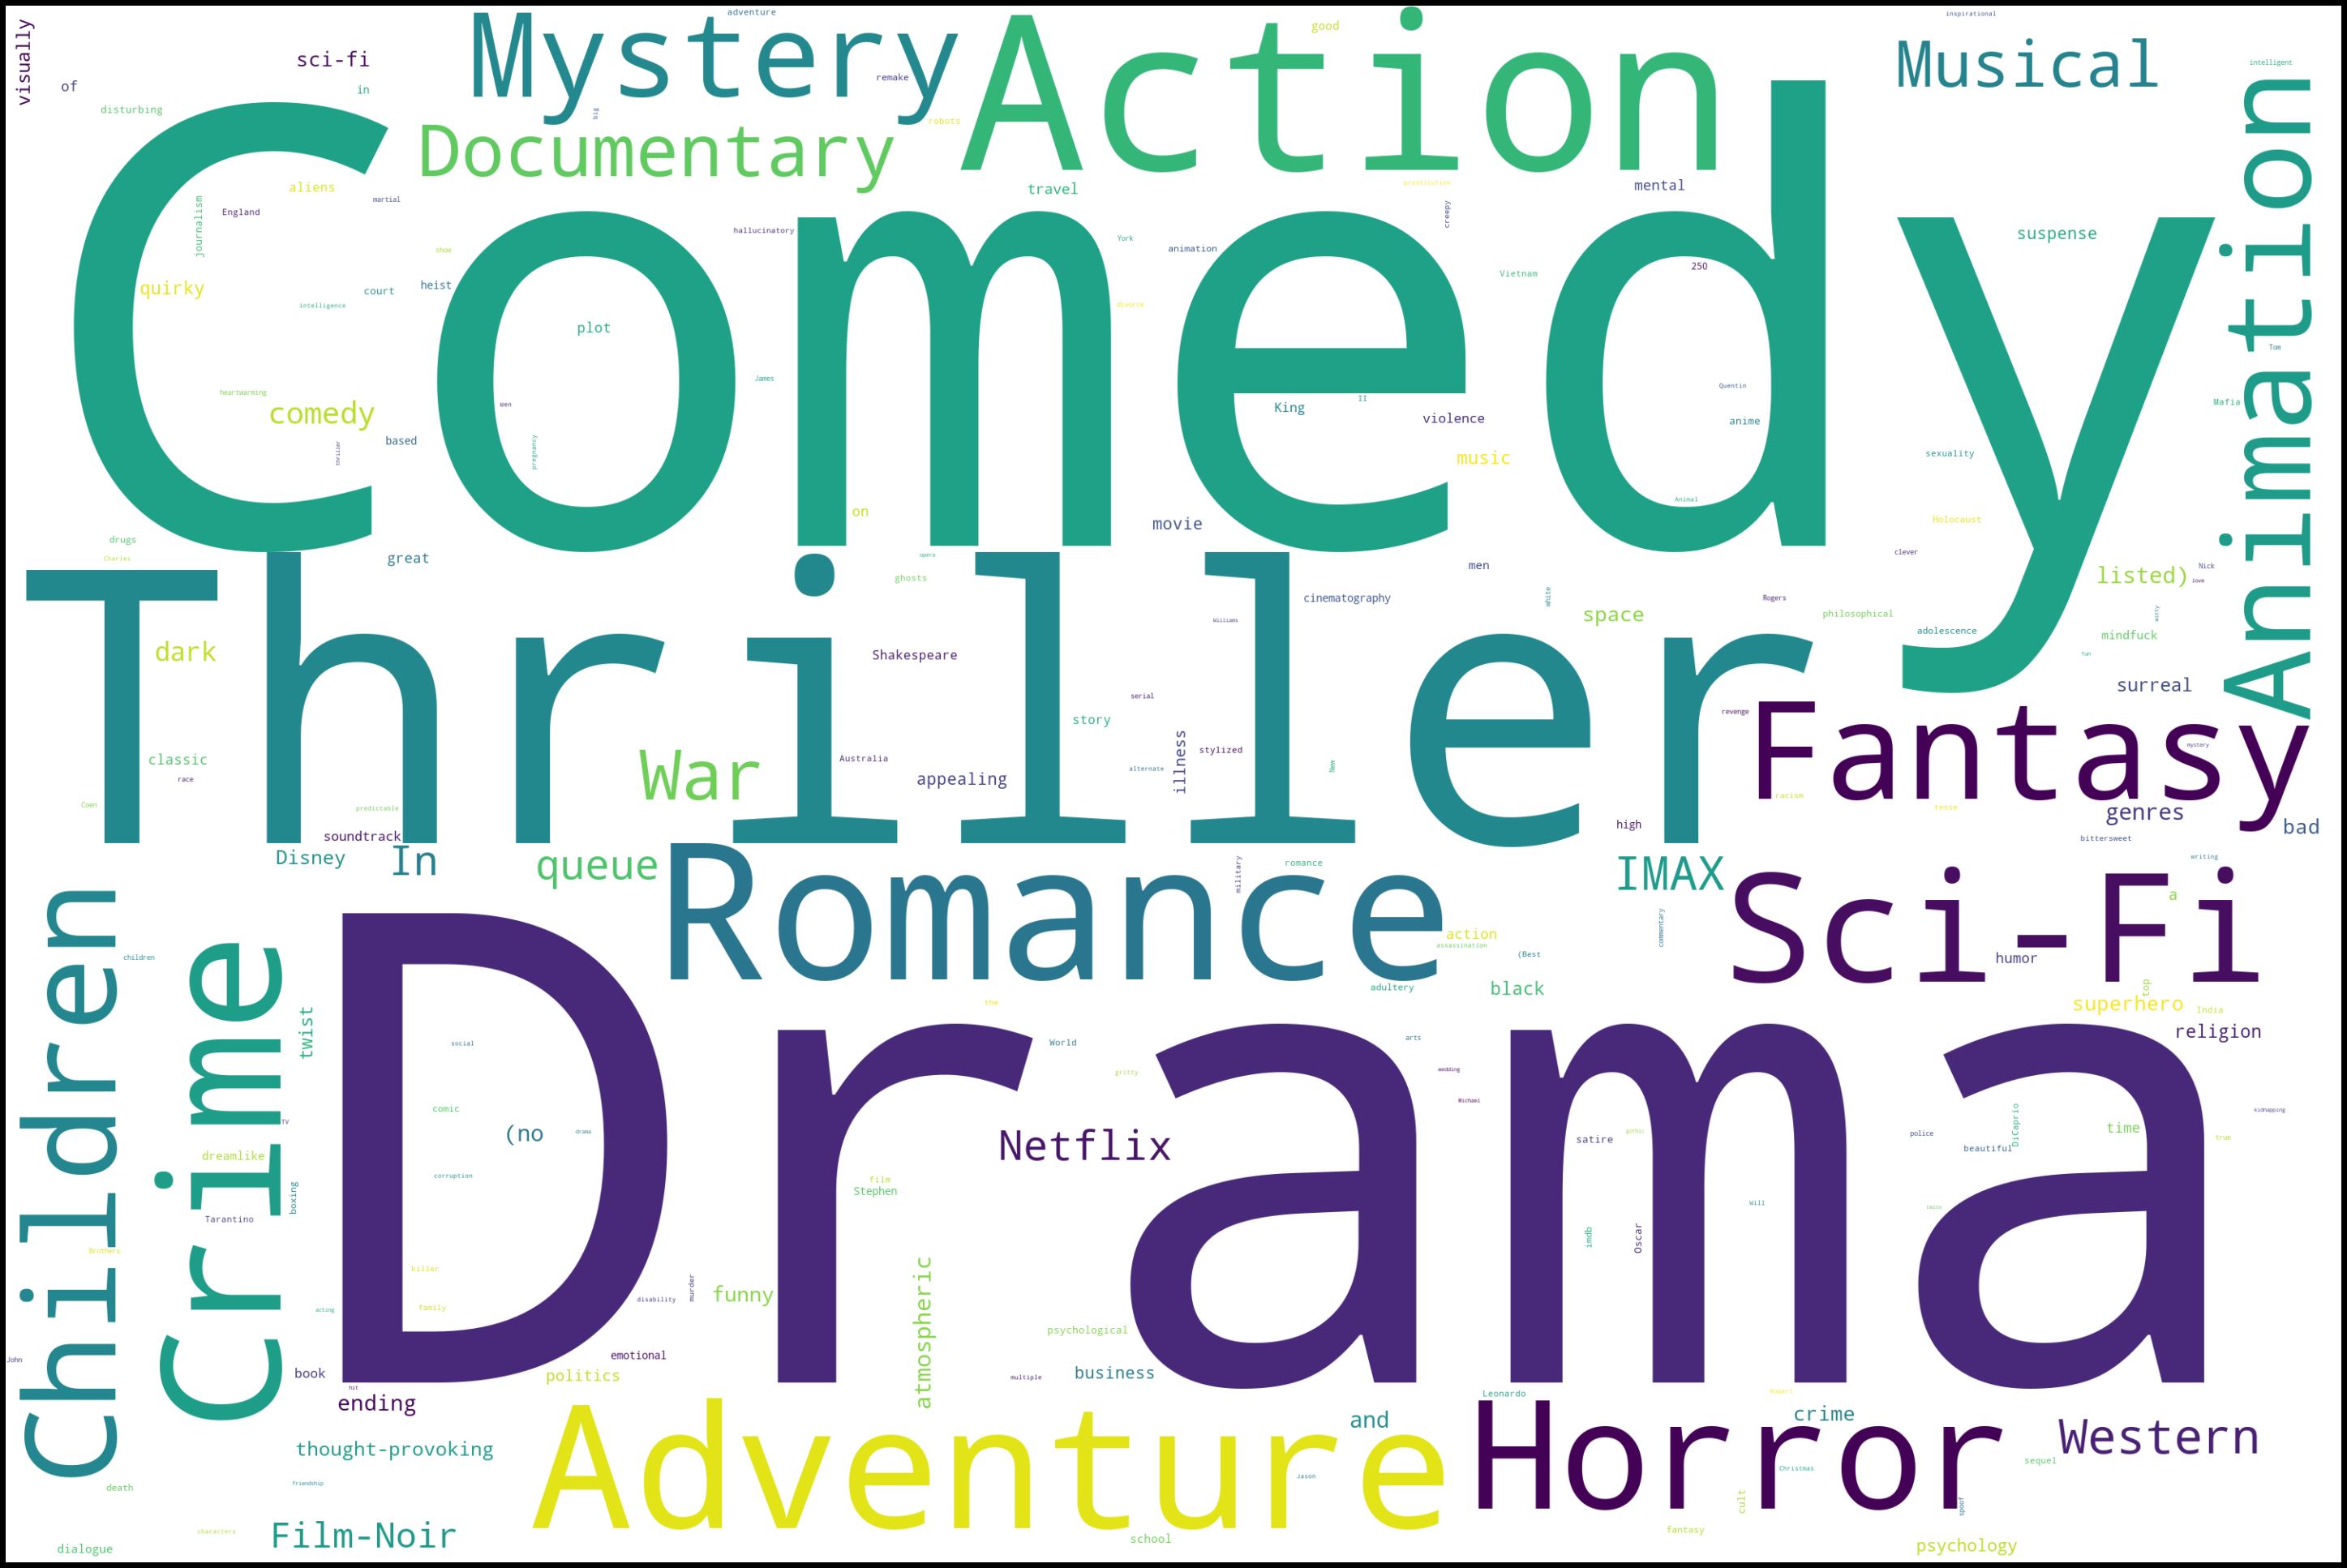

In [8]:
# Filter movie data to only keep the filtered movies
movies_filtered = movies[movies.movieId.isin(filtered_movie_ids)]

# Create a dictionary mapping movie names to id's
name_id_map = dict(zip(movies_filtered.title.tolist(), movies_filtered.movieId.tolist()))

# Drop timestamp data 
# Create a mixed dataframe of movies title, genres 
# All user tags given to each movie

mixed = pd.merge(movies_filtered, tags, on='movieId', how='left')

# create metadata from tags and genres
mixed.fillna("", inplace=True)
mixed = pd.DataFrame(mixed.groupby('movieId')['tag'].apply(lambda x: "%s" % ' '.join(x)))


Final = pd.merge(movies_filtered, mixed, on='movieId', how='left')
Final['metadata'] = Final[['tag', 'genres']].apply(lambda x: ' '.join(x), axis = 1)


# visualizing our metadata column

meta_data = {}
for data in Final['metadata'].values:
    all_data = data.split(" ")
    for entry in all_data:
        if entry != '':
            if entry not in meta_data.keys():
                meta_data[entry] = 1
            else:
                meta_data[entry] += 1

wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'white',
    stopwords = STOPWORDS).generate_from_frequencies(meta_data)
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

<h3>Create Movie-User Matrix</h3>

In [9]:
ratings_right_filtered = pd.merge(
                                  movies[['movieId']],
                                  ratings_filtered,
                                  on="movieId",
                                  how="right"
                                 )

ratings_pivoted = ratings_right_filtered.pivot(
                                               index='movieId',
                                               columns ='userId',
                                               values = 'rating'
                                              ).fillna(0)

<h3>Collaborative Latent Based</h3>

In [10]:
# is the number of components we select from matrix sigma
# number of components for collaborative filtering
coll_comp = 200 

svd = TruncatedSVD(n_components=coll_comp) 
latent_matrix = svd.fit_transform(ratings_pivoted)
latent_matrix_df = pd.DataFrame(latent_matrix,index=Final.title.tolist())
latent_matrix_df

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
Toy Story (1995),36.529707,-5.074949,14.235173,1.622985,-2.944133,-2.106465,8.459597,-0.896124,1.883903,1.548117,...,1.376583,0.336871,-0.312209,-1.431837,1.631286,0.035028,0.933635,1.076001,-0.861895,0.491299
Jumanji (1995),20.500767,0.567300,11.452728,-7.383754,-3.484204,3.291779,4.429478,-5.329649,-1.379762,0.414836,...,-0.094443,-1.140018,-1.897654,-1.009869,-0.080974,-0.830869,1.397035,-0.450218,-1.283304,-0.920947
Grumpier Old Men (1995),8.394742,-5.203202,4.239871,-6.200537,-0.290427,1.794150,-1.520623,0.325047,3.292952,2.065457,...,0.692717,0.150375,-0.414571,0.128974,-0.788973,0.158724,0.796799,0.019483,0.205710,-0.761935
Waiting to Exhale (1995),0.407892,-0.669001,0.742325,-0.214372,-0.518757,1.001919,0.209289,-0.549024,0.321803,0.072336,...,-0.195008,0.208960,-0.054276,-0.409144,0.065933,-0.034148,0.184183,-0.021986,0.031667,0.166950
Father of the Bride Part II (1995),5.819264,-1.884678,4.210297,-3.802960,-3.756884,3.096114,1.275007,-1.020384,1.988991,1.351419,...,-0.510812,0.148566,0.486759,-0.850414,-0.794497,-0.347680,0.114933,-0.295804,0.130321,-0.174148
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Black Butler: Book of the Atlantic (2017),0.039748,0.157080,-0.051064,0.007783,0.056425,0.157818,0.171462,0.056862,-0.023724,-0.044905,...,-0.373516,-0.271794,0.382212,-0.028703,-0.141354,-0.177717,-0.374203,0.410582,0.225084,0.165806
No Game No Life: Zero (2017),0.034780,0.137445,-0.044681,0.006810,0.049372,0.138091,0.150029,0.049754,-0.020759,-0.039292,...,-0.326827,-0.237820,0.334435,-0.025115,-0.123685,-0.155502,-0.327427,0.359260,0.196948,0.145080
Flint (2017),0.034780,0.137445,-0.044681,0.006810,0.049372,0.138091,0.150029,0.049754,-0.020759,-0.039292,...,-0.326827,-0.237820,0.334435,-0.025115,-0.123685,-0.155502,-0.327427,0.359260,0.196948,0.145080
Bungo Stray Dogs: Dead Apple (2018),0.034780,0.137445,-0.044681,0.006810,0.049372,0.138091,0.150029,0.049754,-0.020759,-0.039292,...,-0.326827,-0.237820,0.334435,-0.025115,-0.123685,-0.155502,-0.327427,0.359260,0.196948,0.145080


<h3>Content (Metadata) Latent Based</h3>

In [11]:
# number of components for content based method
cont_comp = 400

tfidf_vectors = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectors.fit_transform(Final['metadata'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=Final.index.tolist())


# Compress with SVD
svd = TruncatedSVD(n_components=cont_comp)
latent_matrix_content = svd.fit_transform(tfidf_df)

In [12]:
latent_matrix_content_df = pd.DataFrame(latent_matrix_content[:,0:cont_comp], index=Final.title.tolist())
latent_matrix_content_df.head()

,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399
Toy Story (1995),0.102533,0.082476,0.069582,0.088458,-0.153009,0.011932,0.234247,-0.009963,-0.125975,-0.008711,...,0.009796,0.009303,0.005294,0.001337,0.003987,-0.004055,0.005415,0.004227,0.008302,-0.002320
Jumanji (1995),0.032662,0.008606,0.059263,0.089857,-0.107717,0.007152,0.189329,-0.006471,-0.079107,0.001554,...,0.001635,-0.007570,-0.008907,-0.034392,0.010091,-0.022523,-0.030656,0.023257,-0.019297,0.003335
Grumpier Old Men (1995),0.148103,0.105284,-0.042406,0.123656,0.096379,-0.039215,-0.011899,0.000625,0.004796,-0.002096,...,-0.032208,-0.087826,-0.019558,-0.043758,-0.071369,0.097821,0.030285,-0.137324,-0.000086,0.001668
Waiting to Exhale (1995),0.824794,0.064959,-0.292050,0.382681,0.267588,-0.079997,-0.045788,-0.000784,0.028433,-0.000409,...,0.000120,0.000048,-0.000123,0.000147,-0.000150,0.000212,-0.000244,-0.000007,0.000033,-0.000216
Father of the Bride Part II (1995),0.113246,0.120812,-0.006388,-0.037367,-0.006870,0.010385,-0.009212,-0.002238,0.004315,-0.011441,...,-0.000800,-0.001213,0.000202,-0.003124,-0.000897,0.000977,-0.000052,-0.002045,0.000373,-0.001864


###  Recommendation by Cosine Similarity on Latent Content and Collaborative Matrices

In [25]:
def recommend_movie(movie):
    # Take the latent vectors for a selected movie from both content and collaborative matrixes
    a_1 = np.array(latent_matrix_df.loc[movie]).reshape(1, -1)
    a_2 = np.array(latent_matrix_content_df.loc[movie]).reshape(1, -1)

    # Calculate the similartity of this movie with the others in the list
    score_1 = cosine_similarity(latent_matrix_df, a_1).reshape(-1)
    score_2 = cosine_similarity(latent_matrix_content_df, a_2).reshape(-1)

    # form a data frame of similar movies 
    dictDf = {'content': score_1 , 'collaborative': score_2} 
    similar = pd.DataFrame(dictDf, index = latent_matrix_df.index )

    #sort it on the basis of either: content, collaborative
    similar.sort_values('content', ascending=False, inplace=True)

    return similar[1:].head(11)

### Matrix Factorization

In [14]:
# Read in our rating data
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings_filtered[['userId','movieId','rating']], reader)

# Train SVD on 80% of known rates
trainset, testset = train_test_split(data, test_size=.20)
model = SVD()
model.fit(trainset)
predictions = model.test(testset)

# check the accuracy using Root Mean Square Error
accuracy.rmse(predictions)

RMSE: 0.8790


0.8789984032774161

<h3>Recommending Unseen Movies to Users in Dataset</h3>

In [15]:
#Recommend movies based on their predicted rating as determined by the SVD model
def predict_movie_and_rating(user_id):
    
    if user_id in ratings_filtered.userId.unique():
        
        # List of movies that the user has seen
        movie_id_list = ratings_filtered[ratings_filtered.userId == user_id].movieId.tolist()
        
        # List of movies that the user has not seen
        unseen = {k: v for k,v in name_id_map.items() if not v in  movie_id_list}        
        scores = []
        
        # For each movie that is unseen use the SVD model to predict that movie's rating
        for movie_id, name in unseen.items():     
        
            predicted = model.predict(user_id, name)
            scores.append((movie_id, predicted[3])) 
        
        # Make a dataframe for the recommendations
        recommendations = pd.DataFrame(scores, columns = ['movies', 'ratings'])
        recommendations.sort_values('ratings', ascending=False, inplace=True) # Sort by decreasing scores as we want higher rated movies at the top
        recommendations.set_index('movies', inplace=True)    
        
        return recommendations.head(10) # Return the top 10 predicted rated movies
    
    else:
        print("User Id does not exist in the list!")
        return None

<h3>Using the Recommender</h3>

In [26]:
# movie string must be the exact title from dataset
movie = 'Sin City (2005)'
recommend_movie(movie)

,content,collaborative
Kill Bill: Vol. 1 (2003),0.745993,0.140266
V for Vendetta (2006),0.741542,0.156077
300 (2007),0.710387,0.077782
Batman Begins (2005),0.706137,0.222380
Kill Bill: Vol. 2 (2004),0.683022,0.137418
"Matrix Reloaded, The (2003)",0.662868,0.145585
Shaun of the Dead (2004),0.641462,-0.000019
"Matrix Revolutions, The (2003)",0.636565,0.145585
Kiss Kiss Bang Bang (2005),0.635385,0.140754
"Pan's Labyrinth (Laberinto del fauno, El) (2006)",0.632620,0.041737


In [17]:
# popular user id's are: [68, 610, 274]

predict_movie_and_rating(610)

,ratings
movies,
Wallace & Gromit: The Wrong Trousers (1993),4.635065
Wallace & Gromit: The Best of Aardman Animation (1996),4.620718
Chinatown (1974),4.593565
Lawrence of Arabia (1962),4.559903
Laputa: Castle in the Sky (Tenkû no shiro Rapyuta) (1986),4.530641
All About Eve (1950),4.527448
Cinema Paradiso (Nuovo cinema Paradiso) (1989),4.501175
Paths of Glory (1957),4.499499
"Philadelphia Story, The (1940)",4.497408


In [18]:
display_user = movie_data[movie_data.userId == 68]
display_user = display_user.sort_values("rating", ascending=False)
display_user.head(5)

,userId,movieId,rating,timestamp,title,genres
35310,68,4306,5.0,1158531222,Shrek (2001),Adventure|Animation|Children|Comedy|Fantasy|Ro...
67775,68,76093,5.0,1291164826,How to Train Your Dragon (2010),Adventure|Animation|Children|Fantasy|IMAX
67496,68,58998,5.0,1208743388,Forgetting Sarah Marshall (2008),Comedy|Romance
84231,68,54881,5.0,1269122731,"King of Kong, The (2007)",Documentary
46001,68,2081,5.0,1158532733,"Little Mermaid, The (1989)",Animation|Children|Comedy|Musical|Romance
